In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/soil-classification/soil_classification-2025/test'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-classification/soil_classification-2025/test/img_0f035b97.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_f13af256.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_15b41dbc.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_cfb4fc7a.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_683111fb.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_c4bd7b3e.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_4ccce0f8.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_86faa98d.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_c448342c.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_e7f7c796.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_20eba00e.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_32d1903f.jpg
/kaggle/input/soil-classific

In [100]:
# Importing all the libraries 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**LOADING AND DATA PREPROCESSING** 

In [101]:
# Load labels
label_df = pd.read_csv("/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv")

In [102]:
# Checking unique soil types
print("Unique soil types:", label_df['soil_type'].unique())

# To label the possible classification
label_mapping = {
    'Clay soil': 0,
    'Red soil': 1,
    'Alluvial soil': 2,
    'Black Soil': 3
}

label_df = label_df[label_df['soil_type'].isin(label_mapping.keys())]
label_df['label'] = label_df['soil_type'].map(label_mapping).astype(str)

Unique soil types: ['Alluvial soil' 'Clay soil' 'Red soil' 'Black Soil']


In [103]:
# Image directory
train_img_dir = "/kaggle/input/soil-classification/soil_classification-2025/train/"

# Train-val split
train_df, val_df = train_test_split(label_df, test_size=0.2, stratify=label_df['label'], random_state=42)

In [104]:
# Class weights to handle imbalance
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

Class Weights: {0: 1.5361635220125787, 1: 1.1575829383886256, 2: 0.5787914691943128, 3: 1.3202702702702702}


**IMAGE PREPROCESSING WITH DATA AUGMENTATION**

In [105]:
# Data generators
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_img_dir,
    x_col='image_id',
    y_col='label',
    target_size=img_size,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=train_img_dir,
    x_col='image_id',
    y_col='label',
    target_size=img_size,
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False
)


Found 970 validated image filenames belonging to 4 classes.
Found 244 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 7 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


**CNN MODEL**

In [106]:
# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [107]:
# Training the CNN model
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5100 - loss: 2.7308 - val_accuracy: 0.7951 - val_loss: 0.5523
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7401 - loss: 0.6496 - val_accuracy: 0.7992 - val_loss: 0.4528
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7747 - loss: 0.5756 - val_accuracy: 0.8197 - val_loss: 0.3973
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7931 - loss: 0.5055 - val_accuracy: 0.8484 - val_loss: 0.3316
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7900 - loss: 0.5240 - val_accuracy: 0.7828 - val_loss: 0.4605
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8326 - loss: 0.4174 - val_accuracy: 0.8402 - val_loss: 0.3209
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8193 - loss: 0.3624 - val_accuracy: 0.8443 - val_loss: 0.3426
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8495 - loss: 0.3672 - val_accuracy: 0.8238 - val_loss:

**PREDICTATIONS**

In [108]:
# Predicting on validation set
val_preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step


In [109]:
# Evaluation of the model 
target_names = ['Clay soil', 'Red soil', 'Alluvial soil', 'Black Soil']
report = classification_report(
    y_true, y_pred,
    target_names=target_names,
    output_dict=True,
    zero_division=0
)

f1_scores = [report[name]['f1-score'] for name in target_names]
print("F1 scores per class:", f1_scores)
print("Minimum F1-score:", min(f1_scores))

F1 scores per class: [0.6909090909090908, 0.9814814814814815, 0.8241758241758242, 0.9772727272727273]
Minimum F1-score: 0.6909090909090908


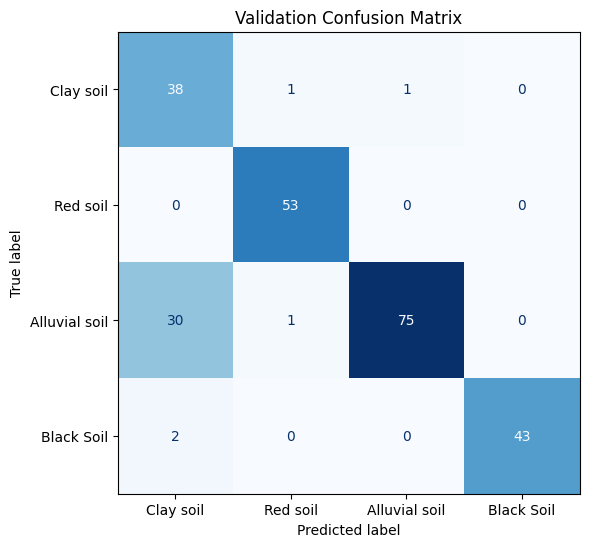

In [110]:
# Output analysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

target_names = ['Clay soil', 'Red soil', 'Alluvial soil', 'Black Soil']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Validation Confusion Matrix")
plt.show()


In [111]:
# Creating test ImageDataGenerator like before
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os

# Define explicit class index-to-label mapping
label_mapping = {
    0: 'Clay soil',
    1: 'Red soil',
    2: 'Alluvial soil',
    3: 'Black Soil'
}

test_df = pd.read_csv("/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv")
test_dir = "/kaggle/input/soil-classification/soil_classification-2025/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='image_id',
    y_col=None,
    target_size=(224, 224),
    class_mode=None,
    batch_size=32,
    shuffle=False,
)

# Predictions on test data
test_predictions = model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Map numeric predictions to soil type names
test_pred_soil_types = [label_mapping[i] for i in test_pred_classes]
valid_image_ids = [os.path.basename(fname) for fname in test_generator.filenames]
valid_df = pd.DataFrame({
    'image_id': valid_image_ids,
    'soil_type': test_pred_soil_types
})

# Merge with original test set to preserve full order
submission_df = test_df.merge(valid_df, on='image_id', how='left')

# Fill any missing predictions with most common label
most_common_soil = valid_df['soil_type'].mode()[0]
submission_df['soil_type'] = submission_df['soil_type'].fillna(most_common_soil)
submission_df['soil_type'] = submission_df['soil_type'].astype(str)

submission_df.to_csv("submission.csv", index=False)
print("Submission saved, Shape:", submission_df.shape)


Found 339 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 424ms/step
Submission saved, Shape: (341, 2)


In [112]:
print(submission_df.head())


            image_id      soil_type
0  img_cdf80d6f.jpeg  Alluvial soil
1   img_c0142a80.jpg      Clay soil
2   img_91168fb0.jpg  Alluvial soil
3   img_9822190f.jpg      Clay soil
4  img_e5fc436c.jpeg      Clay soil


In [114]:
submission_df.to_csv("submission.csv", index=False)

